# Introduction to Computer Vision

This notebook will give an introduction to computer vision fundamentals grounded in the corresponding mathematical concepts from geometry and algebra.

## What is Computer Vision?

To start off, perhaps it would be helpful to discuss what exactly is computer vision? Different people use this broad term for different things, but broadly computer vision involving designing algorithms and systems that take in visual inputs to derive some useful understanding of the 3D world.

The earliest work in this field was labeled under the banner of "image processing," working with 2D images from cameras. By the late 1960's, you see research robots like [SRI's Shaky](https://en.wikipedia.org/wiki/Shakey_the_robot) using analog television cameras to do basic tasks. Many early image processing advances were made in medical applications. In particular the invention of CT scans, which use 2D x-ray images from multiple angles to reconstruct a 3D scan, earned Allan M. Cormack and Godfrey N. Hounsfield the [1979 Nobel Prize in Physiology or Medicine](https://www.nobelprize.org/prizes/medicine/1979/summary/).

As cameras became better, cheaper, and more ubiquitous, computer vision has become a part of our everyday lives. From smartphones to cars, more and more products are integrating vision based algorithms. Furthermore, computer vision has found a key role in factories and industrial applications for driving robots and inspection systems.

Moving forward, the emergence of new types of sensors such as LIDAR and light-field cameras capable of directly capturing 3D representations of the world are driving new algorithms and use cases. More than any other field, computer vision has embraced deep learning and neural networks as a tool for tackling challenging classification and segmentation tasks. This is an exciting time for computer vision, so let's jump right in!

We will be using a Jupyter notebook for this course. Select the code block and hit Shift+Enter to run it and import all the Python libraries we will need.

In [ ]:
%matplotlib inline
import numpy as np
import scipy.signal
import cv2

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import collections
from mpl_toolkits.mplot3d import art3d

print("Import done!")

Import done!


# Part 1: Images

Before we can start talking about image processing, let's take a look at how 2D images are stored and intepreted by computers. At the simplest level, a digital image is a grid of values. For images from a camera, these values usually represent brightness of some kind and are called *pixels*. Raw images are integer valued, as in each value is stored as a positive integer. The range of values is set by their *bit-depth*, with the number of bits per pixel setting the number of levels that can be stored. For instance, the pixels of an 8-bit image can have values in the range $[0, 2^8]$, or 0-255.

## 1.1 Grayscale Images

Let's take a look at an actual image. We'll start with grayscale image, which have a single value or channel per pixel and so have no color information.

In [ ]:
! curl https://upload.wikimedia.org/wikipedia/commons/thumb/a/ab/Abraham_Lincoln_O-77_matte_collodion_print.jpg/192px-Abraham_Lincoln_O-77_matte_collodion_print.jpg -o lincoln.jpg

lincoln = cv2.imread('lincoln.jpg', cv2.IMREAD_GRAYSCALE)

In [ ]:
print(lincoln)
plt.imshow(lincoln, cmap='gray')
plt.show()

For performing work on images, it is often convenient to convert the integer valued image into a normalized, floating point image that takes values from 0.0-1.0. You can think of this as representing a percentage brightness in each pixel, and has some advantages when combining or doing math on images.

In [ ]:
print("Integer range:", lincoln.min(), "to", lincoln.max())

lincoln_float = lincoln.astype(float) / 255
print(lincoln_float)
print("Float range:", lincoln_float.min(), "to", lincoln_float.max())

One thing to note is that the origin of the image is at the top right. This means positive x is to the right, and positive y is to the bottom. In addition, the image array is addressed first with y, then with x. This convention is a byproduct of the beam scan pattern of analog CRT televisions. As a result, it may be helpful to think about indexing discrete images as `image[row, column]`.

## Exercise

To see how this works in practice, let's write some simple functions for flipping an image horizontally and vertically. Hint: remember how Numpy slicing works with a negative step count!

In [ ]:
def flip_horizontal(image):
  return image[:, ::-1]

def flip_vertical(image):
  return image[::-1, :]

In [ ]:
plt.imshow(flip_horizontal(lincoln), cmap='gray')
plt.title("Flip horizontal")

plt.figure()
plt.imshow(flip_vertical(lincoln), cmap='gray')
plt.title("Flip vertical")
plt.show()

## 1.2 Point operations

Now that we have some image data, let's do something with it. The simplest operations transform an image one pixel at a time. These are commonly called point operations since they only depend on each individual point in an image.

Let's take a look at what happens when we shift or scale pixel values. Of course, if a remapped value goes outside the acceptable range of values, we need to clamp it.

In [ ]:
def clamp(float_image):
  return float_image.clip(0.0, 1.0)

plt.figure()
plt.title("Original")
plt.imshow(clamp(lincoln_float), cmap='gray', vmin=0.0, vmax=1.0)

plt.figure()
plt.title("Scale by 1.5")
plt.imshow(clamp(lincoln_float * 1.5), cmap='gray', vmin=0.0, vmax=1.0)

plt.figure()
plt.title("Scale by 0.5")
plt.imshow(clamp(lincoln_float * 0.5), cmap='gray', vmin=0.0, vmax=1.0)

plt.figure()
plt.title("Shift by 0.5")
plt.imshow(clamp(lincoln_float + 0.5), cmap='gray', vmin=0.0, vmax=1.0)

plt.figure()
plt.title("Shift by -0.5")
plt.imshow(clamp(lincoln_float - 0.5), cmap='gray', vmin=0.0, vmax=1.0)

plt.show()

Notice how multiplying by a constant stretches out or squeezes differences between low and high values. This is why contant multiplication is often used to implement contrast adjustment. In the same way, a constant shift is used to implement brightness adjustment.

To better see this, we can create a histogram of the values using `plt.hist`. Note that we have to flatten the image first, since we want to look at all of the pixels together rather than row by row.

In [ ]:
plt.figure()
plt.title("Original histogram")
plt.hist(lincoln_float.flatten(), bins=20, range=(0, 1))

plt.figure()
plt.title("Scale by 1.5 histogram")
plt.hist(clamp(lincoln_float * 1.5).flatten(), bins=20, range=(0, 1))

plt.figure()
plt.title("Shift by 0.5 histogram")
plt.hist(clamp(lincoln_float * 0.5).flatten(), bins=20, range=(0, 1))

plt.show()

### Exercise

Of course, the point operation can be any function that takes in a pixel value and outputs a different pixel value. Let's try implementing a shadow boost function, that keeps pixels brighter than some threshold the same, but scales the brightness of dark pixels by some constant.

In [ ]:
def highlight_boost(image, threshold, scale):
  return np.where(image > threshold, image, image * scale)

plt.figure()
plt.title("Original")
plt.imshow(clamp(lincoln_float), cmap='gray', vmin=0.0, vmax=1.0)

plt.figure()
plt.title("Shadow Boost")
plt.imshow(clamp(highlight_boost(lincoln_float, 0.4, 2)), cmap='gray', vmin=0.0, vmax=1.0)

plt.figure()
plt.title("Shadow Boost Histogram")
plt.hist(clamp(highlight_boost(lincoln_float, 0.4, 2)).flatten(), bins=20, range=(0, 1))
plt.show()

## 1.3 Linear Filtering and Convolution

Point operations are great for doing bulk adjustments across the image, but they only consider one pixel at a time. The next major class of operations operate on groups of pixels. The way this works is that we remap each pixel to some function of the pixel values in its viscinity. 

The most commonly used subset of these are called linear filters, where the output values is a linear combination of the pixels around a each input pixel. This is usually done using the operation of convolution. A small mask or *kernel* of scaling factors is overlaid on each pixel, and the sum of the products of this mask with the underlying pixel values is used as the output pixel value. This filter kernel is then slid across the image to get new values for each pixel.

![Convolution](https://www.pyimagesearch.com/wp-content/uploads/2016/06/convolutions_kernel_sliding.jpg)

Let's make this more concrete with an example. Let's blur an image by taking the average of all the pixels in a 3x3 area around each input pixel. There are nine pixels in this area, so the output value will be the sum of all the pixels in this 3x3 neighborhood divided by 9. Alternatively, we each pixel contributes 1/9 times its value to end output value.

In [ ]:
kernel = np.ones((3,3)) / 9
print(kernel)

Now we use the convolve2D function from scipy to convolve an image with this filter.

In [ ]:
blurred = scipy.signal.convolve2d(lincoln_float, kernel)
plt.imshow(blurred, cmap='gray')
plt.show()

### Exercise
Of course, we can get an even smoother blur by average across a larger area. Try writing a function that generates larger blur filter kernels, and see what happens. This filter is commonly known as a box blur. 

In [ ]:
def box_blur_kernel(size):
  return np.ones((size,size)) / size**2

plt.figure()
plt.title("Original")
plt.imshow(lincoln_float, cmap='gray')
plt.show()

plt.figure()
plt.title("Size 5 blur")
plt.imshow(clamp(scipy.signal.convolve2d(lincoln_float, box_blur_kernel(5))), cmap='gray')
plt.show()

plt.figure()
plt.title("Size 7 blur")
plt.imshow(clamp(scipy.signal.convolve2d(lincoln_float, box_blur_kernel(7))), cmap='gray')
plt.show()

## 1.4 Edge Detection

One major use of linear filtering is for edge detection. Fundamentally, an edge is a place where the pixel values changes sharply. In math terms, the derivative at that pixel is very high. If you remember from calculus, for a discrete function you can approximate the derivative by taking the difference over a small distance.

Let's construct a filter that adds up the differences between the target pixel and all its neighbors.

In [ ]:
kernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
print(kernel)
filtered = scipy.signal.convolve2d(lincoln_float, kernel)
plt.imshow(clamp(filtered), cmap='gray')
plt.show()

As a bonus, what happens when we highlight these pixels on top of the original image? We can implement this by adding an extra copy of the original pixel value, so increase the mask's value at the anchor pixel's entry by 1.

In [ ]:
kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
print(kernel)
filtered = scipy.signal.convolve2d(lincoln_float, kernel)
plt.imshow(clamp(filtered), cmap='gray')
plt.show()

# Part 2: Color

Now that we have the basics of image manipulation under our belt, let's take things to the next dimension: color images!

## 2.1 What is color, really?

In elementary school, we are taught that colored light is made up of three primary colors that we can mix together to make any other color. This is often shown in a kind of color venn diagram or color wheel

![Color wheel](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/AdditiveColor.svg/240px-AdditiveColor.svg.png)

In physics, you probably learned that the color of light is dependent on the frequency of light waves. This is usually demonstrated by a prism breaking light into a continuous rainbow as different frequencies of light are bent differently.

![Visible Spectrum](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Linear_visible_spectrum.svg/500px-Linear_visible_spectrum.svg.png)

But there's a bit of a problem here. Just putting some red and green photons together doesn't change their frequency to yellow. And a cyan photon can't magically split apart into a blue and green photon when it enters a camera. And why are red, green, and blue so special?

So we come to the next generation of color theory: the tristimulus model. The light sensing cone cells in our eyes have three different kinds of pigments. Each pigment produces a different level of response when it absorbs different frequencies of light.

![Cone color response](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Cones_SMJ2_E.svg/500px-Cones_SMJ2_E.svg.png)

Our brains then combine the level of response from each of the three classes of cone cells to estimate what frequency of light we're looking at. For camera and display makers, this is great news since if we can just stimulate these three classes of cells independently, we can simulate any color we want. The peaks of the three responses are at red, green, and blue. So we have our first color system, RGB.

Note, however, that the three cells aren't completely independent. In other words, we can't pick frequencies that only stimulate one of the three cell types because their response curves overlap. So we can mix red and green light to look *similar* to yellow light, but not *exactly the same* as true yellow light.

On top of this, the brain does all kinds of processing to estimate color that we just can't model with three numbers. For instance, the color brown doesn't appear on any of these models, because it is an artifact of the way our brains judge relative brightness. If you're interested in learning more, the famous book [_Interactions of Color_](hhttps://sccl.bibliocommons.com/item/show/389841118) by Josef Albers lays out a series of exercises to explore how we perceive color with an eye toward graphic design and art.

![Albers](https://collectionapi.metmuseum.org/api/collection/v1/iiif/737721/1626557/restricted)

We're only scratching the surface here, but I hope this gives a bit of background into where RGB comes from and the underlying complexity of color representation.

![XKCD](https://imgs.xkcd.com/comics/color_models.png)

## 2.2 Color images

So to summarize, we need three values in order to represent color as humans see it. So a color image has three values for each pixel. These are usually referred to as channels, so for RGB we have a red channel, a green channel, and a blue channel.

Now remember, OpenCV does things a bit backward, so we're going to need our BGR to RGB function from last lesson.

In [ ]:
def bgr_to_rgb(image):
  # WRITE CODE HERE
  return image[:,:,::-1]

! curl https://cdn.star.nesdis.noaa.gov/GOES17/ABI/FD/GEOCOLOR/678x678.jpg     -o goes_west.jpg

image = bgr_to_rgb(cv2.imread('goes_west.jpg'))
plt.imshow(image)
plt.show()

TODO: Color space, color segmentation

# Part 3: 3D Geometry

Before we can start working with images, we need to understand how we get images in the first place. Fundamentally, an image is a lower-dimensional representation of a higher-dimensional space. We are primarily working with 2D images of our 3D world. Let's go into more detail on how we describe objects in 3D space.

First let's load in some 3D data we'll use later. This the [Utah teapot](https://www.computerhistory.org/revolution/computer-graphics-music-and-art/15/206), the single most famous 3D model in 3D graphics. 

In [ ]:
!pip install numpy-stl
import stl
!curl "https://upload.wikimedia.org/wikipedia/commons/9/93/Utah_teapot_%28solid%29.stl" -o teapot.stl

teapot_stl = stl.mesh.Mesh.from_file('teapot.stl')
teapot_verts = np.unique(np.reshape(teapot_stl.vectors, (-1, 3)), axis=0)
teapot_edges = np.stack([np.roll(teapot_stl.vectors, 1, axis=1), teapot_stl.vectors], axis=2)
teapot_edges = np.sort(teapot_edges.reshape((-1,2,3)), axis=1)
teapot_edges = np.unique(teapot_edges, axis=0).shape

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  460k    0  460k    0     0  1212k      0 --:--:-- --:--:-- --:--:-- 1212k


## 3.1 Geometric Primitives

From middle school geometry, you should remember that the basic building blocks of geometry are points and lines. In particular, a point is simply a spot in space, represented by a set of coordinates. A line or edge is a connection between any two points. Indeed, any two points can form a unique edge. Next, a collection of three or more points connected by edges can form a polygon. Three points connected by three edges is a triangle, four points and four edges is a quadrilateral, etc. Simple stuff.

The exact same terminology extends to 3D. However, we have quite a few more options for playing around with polygons. A collection of interconnected polygons is called a polygon mesh or mesh for short. In the context of meshes, you'll often hear the individual polygons referred to as faces of the mesh. For instance, a simple cube mesh has six rectangular faces.

![Cube mesh](https://haygot.s3.amazonaws.com/questions/1511554_1675028_ans_9e1cc499d8bc4964b5b8f61c490babd7.jpg)

One side note is that computer graphics and GPUs generally use trianglular faces. This is because any collection of three points (or two joined edges) is guarenteed to form a flat triangle. You may remember the theorem from geometry that any three points form a plane. Thus, you can assume any triangle is flat. However, that is not true for polygons with four or more vertices! Thus you'll sometime hear people referring to "triangulation" or "triangulated meshes," which means a mesh has been converted to only contain triangles. Also, since you can always break a polygon into a set of triangles, some CV algorithms will just assume meshes are made of triangles to keep the math simpler.

Let's define some functions to generate nice looking plots of collections of points and edges. For now we'll rely on matplotlib to do drawing. In part 3 we will work toward building our own camera and mini-render engine. I've prewritten some functions to plot vert lists and edge lists.

In [ ]:
def plot2d_verts(vert_list, title="", range=3):
  fig = plt.figure()
  ax = fig.gca()
  plt.scatter(vert_list[:,0], vert_list[:,1])

  plt.xlim(-range,range)
  plt.ylim(-range,range)
  ax.set_aspect('equal')
  ax.set_title(title)
  plt.grid()
  plt.show()

def plot2d_edges(vert_list, edge_list, title="", range=3):
  edge_collection = collections.LineCollection(edge_list, linewidths=2)
  fig = plt.figure()
  ax = fig.gca()
  plt.scatter(vert_list[:,0], vert_list[:,1])

  plt.xlim(-range,range)
  plt.ylim(-range,range)
  ax.set_aspect('equal')
  ax.add_collection(edge_collection)
  ax.set_title(title)
  plt.grid()
  plt.show()

def plot3d_verts(vert_list, title="", range=2, axes_opacity=0.3):
  fig = plt.figure(figsize=plt.figaspect(1))
  ax = fig.gca(projection='3d')
  ax.scatter(vert_list[:,0], vert_list[:,1], vert_list[:,2])
  ax.set_xlim3d(-range, range)
  ax.set_ylim3d(-range, range)
  ax.set_zlim3d(-range, range)
  ax.set_title(title)
  origin_axes = art3d.Line3DCollection([((-range,0,0), (range,0,0)),
                                        ((0,-range,0), (0,range,0)),
                                        ((0,0,-range), (0, 0,range))], colors=((1,0,0,axes_opacity),(0,1,0,axes_opacity),(0,0,1,axes_opacity)), linewidths=2)
  ax.add_collection(origin_axes)
  plt.show()

def plot3d_edges(vert_list, edge_list, title="", range=2, axes_opacity=0.3):
  fig = plt.figure(figsize=plt.figaspect(1))
  ax = fig.gca(projection='3d')
  ax.scatter(vert_list[:,0], vert_list[:,1], vert_list[:,2])
  ax.set_xlim3d(-range, range)
  ax.set_ylim3d(-range, range)
  ax.set_zlim3d(-range, range)
  ax.set_title(title)
  origin_axes = art3d.Line3DCollection([((-range,0,0), (range,0,0)),
                                        ((0,-range,0), (0,range,0)),
                                        ((0,0,-range), (0, 0,range))], colors=((1,0,0,axes_opacity),(0,1,0,axes_opacity),(0,0,1,axes_opacity)), linewidths=2)
  ax.add_collection(origin_axes)
  edge_collection = art3d.Line3DCollection(edge_list)
  ax.add_collection(edge_collection)
  plt.show()

##3.2 Mesh representation

So how do we actually represent a mesh in software? Well, remember that points can be represented by their location in space. So in software, we record the coordinates of the point as a vector. For points in 2D, this is a simple (x, y) pair. For 3D, we add an additional dimension so we end up with a 3D vector (x, y, z)

To keep things simple, let's start with 2D objects and work our way up to 3D. As an exercise, what are the vertices for a unit square (side length 1) sitting in the positive quadrant? Remember there are 4 vertices for a square, so save their coordinates in a shape (4 vertices, 2 dimensions) numpy array.

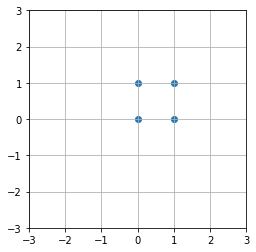

In [ ]:
square_verts = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])

plot2d_verts(square_verts)

Next we need to show how these vertices are connected into edges. Remember that an edge is simply a pair of vertices. So we can write down an edge list as a list of pairs of coordinates. Write down the edge list for our unit square. This is a list of pairs of 2d coordinates, so dimension is going to be (4 edges, pairs of 2, 2 dimensions)

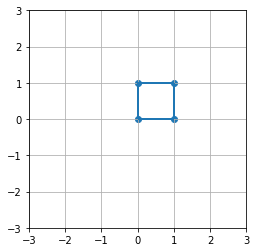

In [ ]:
square_edges = np.array([
                       [[0, 0], [1, 0]],
                       [[0, 0], [0, 1]],
                       [[1, 1], [1, 0]],
                       [[1, 1], [0, 1]]])

plot2d_edges(square_verts, square_edges)

OK, now let's take this to the 3rd dimension! Let's start with a cube. Just like before, we'll define a vertex and edge list.

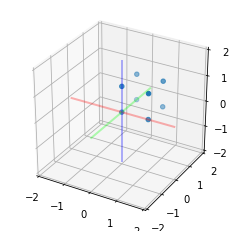

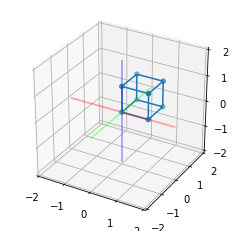

In [ ]:
cube_verts = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0], [1, 1, 0],
                       [0, 0, 1], [1, 0, 1], [0, 1, 1], [1, 1, 1]])

plot3d_verts(cube_verts)

cube_edges = np.array([[[0,0,0], [1,0,0]],
                       [[0,0,1], [1,0,1]],
                       [[0,0,0], [0,0,1]],
                       [[1,0,0], [1,0,1]],
                       [[0,0,0], [0,1,0]],
                       [[0,0,1], [0,1,1]],
                       [[1,0,0], [1,1,0]],
                       [[1,0,1], [1,1,1]],
                       [[0,1,0], [1,1,0]],
                       [[0,1,0], [0,1,1]],
                       [[0,1,1], [1,1,1]],
                       [[1,1,0], [1,1,1]],
                       ])
plot3d_edges(cube_verts, cube_edges)

Of course, we can also draw much larger meshes, like our teapot.

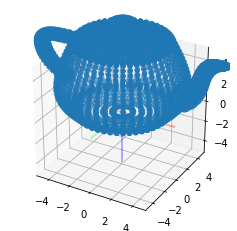

In [ ]:
plot3d_verts(teapot_verts, range=5)

##3.3 Linear Transformations

Now that we have some objects, let's try moving them around a bit. From the basics of linear algebra, you should remember that matricies can be used to represent *linear transformations*. By far the most common transformation we will encounter is rotation. So let's jump right in with rotation matricies and see how this all works in practice.

You can easily Google for rotation matricies and get a bunch of formulas of varying degree of accuracy. However, there's a subtle but import question to be careful about: what exactly is being rotated? 

When you apply a matrix $A$ to a vector $\vec{x}$, there's two ways to think about this transformation. One, your coordinate axes (or reference frame in physics, or camera for CV) stay still and the points the vector represent are moved around. Two, the points are staying the same place but your coordinate axes are moving around, so the coordinates of the point change. The key point is: **a transformation moving points appears the same as a moving the coordinate systems by the inverse transform.**

Think about it this way: If you hold up your phone to the screen, rotate it right, and take a picture, it will look the same as keeping your phone still and rotating your screen *left* by the same amount.

Let's start in 2D to keep things simple. Let's derive the a matrix for a clockwise rotation of the axes by an angle $\theta$. This is equivalent to a *counter-clockwise* rotation of points with a fixed set of coordinate axes.

![Rotation](https://scipython.com/static/media/uploads/examples/rotation-matrix-figure.png)

In the rotated (blue) axes, the point $\begin{bmatrix}1\\0\end{bmatrix}$ (marked in green as $\hat{e}_x')$ now appears above the rotated x axis, at the coordinates $\begin{bmatrix}\cos{\theta}\\\sin{\theta}\end{bmatrix}$. Simarly, the point $\begin{bmatrix}0\\1\end{bmatrix}$ (marked in green as $\hat{e}_y'$) now appears to the left of the rotated y axis, at the point $\begin{bmatrix}-\sin{\theta}\\\cos{\theta}\end{bmatrix}$. Thus, our transformation matrix is $\begin{bmatrix}\cos{\theta}&-\sin{\theta}\\\sin{\theta}&\cos{\theta}\end{bmatrix}$. Take a moment to think this through.

Let's write a function to generate this matrix as a numpy array:




In [ ]:
def rotation_mat_clockwise_axis(theta):
  return np.array([[np.cos(theta), -np.sin(theta)],
                   [np.sin(theta), np.cos(theta)]])

print("Rotate 90º\n", np.round(rotation_mat_clockwise_axis(np.pi / 2), decimals=2))
print("Rotate 180º\n", np.round(rotation_mat_clockwise_axis(np.pi), decimals=2))

Rotate 90º
 [[ 0. -1.]
 [ 1.  0.]]
Rotate 180º
 [[-1. -0.]
 [ 0. -1.]]


Let's apply this matrix to vertices of the unit square we created earlier. We're going to use the @ operator, which is a new feature of Python 3.5+ for performing matrix multiplication. Note we call reshape on the vertices in order to turn the row vectors into column vectors.

Rotation matrix:
 [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


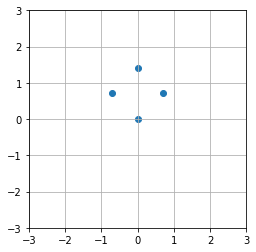

In [ ]:
rot_mat = rotation_mat_clockwise_axis(np.pi/4)
print("Rotation matrix:\n", rot_mat)

transformed_verts = np.empty((square_verts.shape[0], 2, 1))
for i in range(square_verts.shape[0]):
  transformed_verts[i] = rot_mat @ np.reshape(square_verts[i], (2,1))

plot2d_verts(transformed_verts)

$A\times B\times C$ = $(A\times B)\times C$ = $A\times (B\times C)$

One of the important properties of matrix multiplication is that it is associative, so we can combine a bunch of transforms together by matrix multiplying together and get the same result as if we did them one by one. Note though that composing the matricies ahead of time means you do a lot fewer matrix multiplications when you run your algorithm!

Rotation matrix 45:
 [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
Rotation matrix 90:
 [[ 0. -1.]
 [ 1.  0.]]


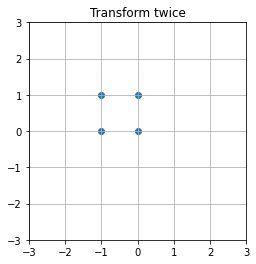

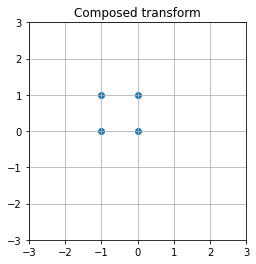

In [ ]:
rot_45 = rotation_mat_clockwise_axis(np.pi/4)
print("Rotation matrix 45:\n", rot_mat)

# Compose two rotations into one matrix
rot_90 = rot_mat @ rot_mat
print("Rotation matrix 90:\n", np.round(rot_90, 2))

# Apply rot_45 twice
transformed_verts = np.empty((square_verts.shape[0], 2, 1))
for i in range(square_verts.shape[0]):
  transformed_verts[i] = rot_mat @ rot_mat @ np.reshape(square_verts[i], (2,1))
plot2d_verts(transformed_verts, "Transform twice")

# Apply rot_90 once
transformed_verts = np.empty((square_verts.shape[0], 2, 1))
for i in range(square_verts.shape[0]):
  transformed_verts[i] = rot_90 @ np.reshape(square_verts[i], (2,1))
plot2d_verts(transformed_verts, "Composed transform")


Now let's take this into 3D. In 2D we only really had one possible axis of rotation. In 3D we have a lot more options. You can pick any 3D vector and use it as an axis of rotation to spin around (Euler's rotation theorem). However this can be a bit tricky to turn into a transformation matrix. 

To keep things simple, one common way to encode 3D rotations are Euler angles. They are named after Euler because he's the first to figure out the math behind them (along with most of rest of geometry). In principle, you can break any 3D rotation into three separate rotations around each of the three axes. 

To implement Euler angles, we just need to derive the matrices for these three elementary rotations. Then using the principle of matrix composition, we can then multiply together the three component rotations into the 3D rotation matrix.

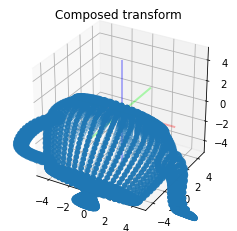

In [ ]:
 def rot_mat_3d(theta):
  return np.array([[1, 0, 0],
                       [0, np.cos(theta), -np.sin(theta)],
                       [0, np.sin(theta), np.cos(theta)]])

rot_mat = rot_mat_3d(np.pi/4)
transformed_verts = np.empty((teapot_verts.shape[0], 3, 1))
for i in range(teapot_verts.shape[0]):
  transformed_verts[i] = rot_mat @ rot_mat @ rot_mat @ np.reshape(teapot_verts[i], (3,1))

plot3d_verts(transformed_verts, "Composed transform", range=5)

# Part 4: Cameras

The tool that performs this conversion from 3D to 2D is a camera, and this action of converting from a higher to lower dimension world is called projection. Let's go through some examples.

##4.1 Projection

The primary problem we are faced with when trying to make a 2D image out of a 3D world is that there are infinitely many more points in 3D than we can represent in 2D. The classical solution to this problem is to make a projection. In other words, collapse lines of points in 3D onto the same point in 2D. In this way, each point in the 3D world can be mapped to a specific point on the 2D image, although each point in the 2D image maps to a ray of points in the 3D world. 

There are a number of different ways to do this so let's go through the most popular ones. Since starting from 3D math is a bit tricky, let's take this down a notch and start by looking at the simplest possbile system: going from a 2D world to a 1D image.

##4.2 Orthographic Projection (2D->1D)

##4.3 Orthographic Projection (3D->2D)

##4.4 Perspective Projection (2D->1D)

Pinhole camera

##4.5 Perspective Projection (3D->2D)